### TIS Strength prediction

This notebook explores to what extent the model can predict the relative strength of different AUG and non AUG start codons + context. Noderer et al. used two MPRA to measure the relative strength of many different start codons + context. Our model also can be coerced to score the strength of different start codons, by injecting the start codon out of frame and checking how much the mean ribosome load is repressed (stronger start codons/contexts should repress more if out of frame than weaker ones).

In [1]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle

import numpy as np
np.random.seed(1337)
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import backend as K
from keras.models import load_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils

Using TensorFlow backend.


In [2]:
pd.options.mode.chained_assignment = None 

### Prepare data

In [3]:
with open("../Data/data_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)

data_df = data_dict["data"]

top_df = data_df[(data_df["utr"].str.contains("ATG") == False) & (data_df["rl"] > 8) & (data_df["set"] == "test")]

tis_aug_df = pd.read_csv("../Data/TIS/tis_efficiencies_aug.tsv", sep='\t')

tis_nonaug_df = pd.read_csv("../Data/TIS/tis_efficiencies_nonaug.tsv", sep='\t')

In [5]:
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5")
new_model = load_model("../Models/basic_model_scaled.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

In [6]:
base_df = top_df.iloc[0:1]
base_encoded = utils.encode_df(base_df, col="utr", output_col=None, variable_len=True)

In [7]:
base_seq = top_df["utr"].iloc[0]
new_seq = [base_seq[:9] + tis + base_seq[20:] for tis in tis_aug_df["sequence"]]

In [8]:
tis_aug_df["utr"] = new_seq
tis_aug_df["library"] = "egfp_unmod_1"
tis_encoded = utils.encode_df(tis_aug_df, col="utr", output_col=None, variable_len=True)

### Predicting the strength of AUG based start codons

In [9]:
predictions_base = paper_model.predict([base_encoded["seq"]])
predictions_tis_aug = paper_model.predict([tis_encoded["seq"]])
delta = (predictions_base.reshape(-1) - predictions_tis_aug.reshape(-1))

Pearson: 0.798, p-val: 0.000, squared: 0.637, Spearman: 0.776, p-val: 0.000


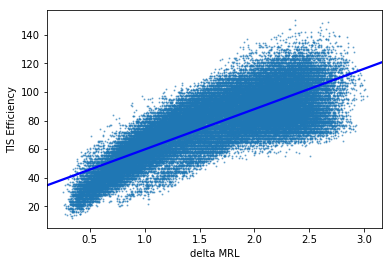

In [10]:
utils.print_corrs(delta, tis_aug_df["efficiency"])
df = pd.DataFrame({"delta MRL":delta, "TIS Efficiency":tis_aug_df["efficiency"]})
x = sns.regplot(x='delta MRL', y="TIS Efficiency", data=df, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

In [11]:
predictions_base = new_model.predict([base_encoded["seq"], base_encoded["library"]])
predictions_tis_aug = new_model.predict([tis_encoded["seq"], tis_encoded["library"]])
delta = (predictions_base.reshape(-1) - predictions_tis_aug.reshape(-1))

Pearson: 0.791, p-val: 0.000, squared: 0.626, Spearman: 0.766, p-val: 0.000


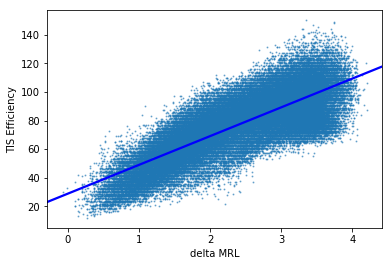

In [12]:
utils.print_corrs(delta, tis_aug_df["efficiency"])
df = pd.DataFrame({"delta MRL":delta, "TIS Efficiency":tis_aug_df["efficiency"]})
x = sns.regplot(x='delta MRL', y="TIS Efficiency", data=df, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

We see that the model can predict the strength of AUG based codons very well. This suggests that the model has learned the sequence features of strong and weak start codons

In [171]:
corrs = []
for i in range(50-11):
    base_seq = top_df["utr"].iloc[0]
    new_seq = [base_seq[:i] + tis + base_seq[i+11:] for tis in tis_aug_df["sequence"]]
    tis_aug_df["utr"] = new_seq
    tis_aug_df["library"] = "egfp_unmod_1"
    tis_encoded = utils.encode_df(tis_aug_df, col="utr", output_col=None, variable_len=True)
    predictions_base = new_model.predict([base_encoded["seq"], base_encoded["library"]])
    predictions_tis_aug = new_model.predict([tis_encoded["seq"], tis_encoded["library"]])
    delta = (predictions_base.reshape(-1) - predictions_tis_aug.reshape(-1))
    corrs.append(utils.pearson_r(delta, tis_aug_df["efficiency"], squared=False)[0])

In [185]:
print(corrs)

[0.748528173454999, 0.6606056242067823, 0.12023467267219426, 0.7166457095842272, 0.6267730971324876, 0.021959555857783294, 0.6979920722362928, 0.6839643636516403, 0.14869463659012877, 0.7913691984583796, 0.6392506784497568, -0.016056074326217216, 0.7289887934681594, 0.6556142496615911, 0.0033069299043593523, 0.7404125493032073, 0.60875712410892, -0.14247528390098366, 0.7001143701167303, 0.7041868453146, 0.06098121035775438, 0.67267947709138, 0.6535414364725001, 0.14803156018567692, 0.7845216365399469, 0.699516902187245, 0.05813622751081182, 0.719818121635679, 0.7317601155002257, 0.13889076070585168, 0.7685933229278263, 0.7044188322017974, 0.025964778105892008, 0.6683872383441162, 0.6869338259125904, -0.026442077939076995, 0.5395551523368306, 0.7292022487989375, -0.23974835400062242]


In [186]:
idx = np.flip(np.arange(1,51)) % 3 # computes the frame
np.array(corrs)[idx[:39] > 0] # all  out of frame positions
print(np.mean(np.array(corrs)[idx[:39] > 0]))

0.6946973522729558


### Non-aug start codons

In [36]:
def score(tis_df, base_df, model, start=9, length=11, treat_aug="", paper=False):
    tis_df = tis_df.copy()
    base_seq = base_df["utr"].iloc[0]
    if treat_aug=="buffer":
        new_seq = [base_seq[:start-1] + "C" + tis + "C" + base_seq[start+length+1:] for tis in tis_df["TIS_Sequence"]]
    else:
        new_seq = [base_seq[:start] + tis + base_seq[start+length:] for tis in tis_df["TIS_Sequence"]]    
    tis_df["utr"] = new_seq
    if treat_aug=="remove":
        tis_df = tis_df[(tis_df["utr"].str.contains("AUG") == False) & (tis_df["utr"].str.contains("ATG") == False)]
    tis_df["library"] = "egfp_unmod_1"
    tis_encoded = utils.encode_df(tis_df, col="utr", output_col=None, variable_len=True)
    if paper:
        predictions_base = model.predict([base_encoded["seq"]])
        predictions_tis_nonaug = model.predict([tis_encoded["seq"]])
    else:
        predictions_base = model.predict([base_encoded["seq"], base_encoded["library"]])
        predictions_tis_nonaug = model.predict([tis_encoded["seq"], tis_encoded["library"]])
    delta = (predictions_base.reshape(-1) - predictions_tis_nonaug.reshape(-1))
    utils.print_corrs(delta, tis_df["TIS_Efficiency"])
    df = pd.DataFrame({"delta MRL":delta, "TIS Efficiency":tis_df["TIS_Efficiency"]})
    x = sns.regplot(x='delta MRL', y="TIS Efficiency", data=df, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()
    return df

In [29]:
# remove those that also add an uAUG
tis_nonaug_df_sub = tis_nonaug_df[tis_nonaug_df["TIS_Sequence"].str.contains("AUG") == False]

Pearson: 0.503, p-val: 0.000, squared: 0.253, Spearman: 0.239, p-val: 0.000


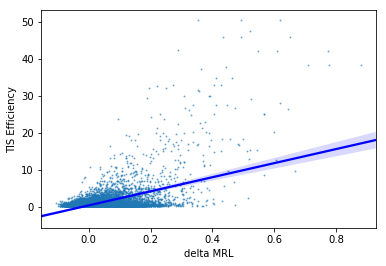

In [37]:
df = score(tis_nonaug_df_sub, top_df, paper_model, start=9, length=8, treat_aug="remove", paper=True)

Pearson: 0.465, p-val: 0.000, squared: 0.216, Spearman: 0.180, p-val: 0.000


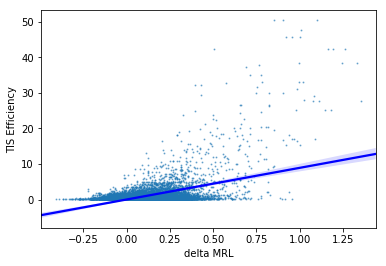

In [33]:
df = score(tis_nonaug_df_sub, top_df, new_model, start=8, length=8, treat_aug="remove", paper=False)

Prediction of the strength of non-start codons appears more difficult. We split by type to see what is going on

### Specific non-AUG starts

CUG

Pearson: 0.785, p-val: 0.000, squared: 0.616, Spearman: 0.581, p-val: 0.000


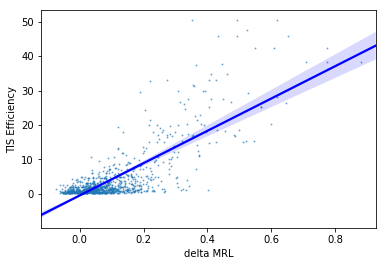

In [40]:
# CUG
cug_df = tis_nonaug_df_sub[tis_nonaug_df_sub["TIS_Sequence"].str[-4:-1] == "CUG"]
df = score(cug_df, top_df, paper_model, start=9, length=8, paper=True)

Pearson: 0.794, p-val: 0.000, squared: 0.630, Spearman: 0.523, p-val: 0.000


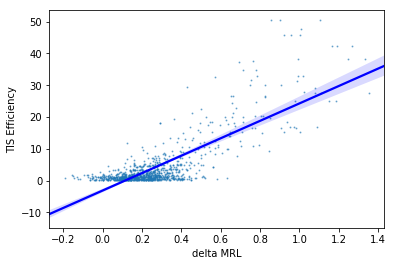

In [41]:
result_df = score(cug_df, top_df, new_model, start=8, length=8, treat_aug="remove", paper=False)

For CUG, prediction is almost as good as for AUG

GUG

Pearson: 0.474, p-val: 0.000, squared: 0.224, Spearman: 0.377, p-val: 0.000


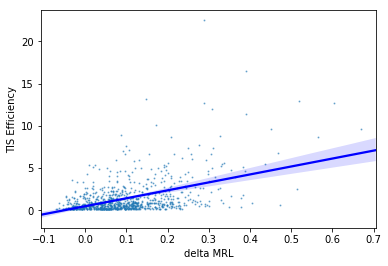

In [19]:
# GUG
gug_df = tis_nonaug_df_sub[tis_nonaug_df_sub["TIS_Sequence"].str[-4:-1] == "GUG"]
df = score(gug_df, top_df, paper_model, start=9, length=8, paper=True)

Pearson: 0.398, p-val: 0.000, squared: 0.158, Spearman: 0.212, p-val: 0.000


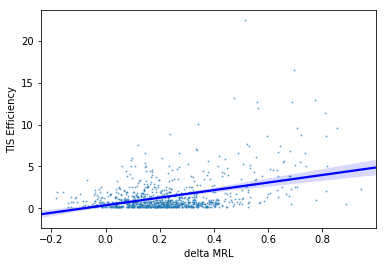

In [20]:
df = score(gug_df, top_df, new_model, start=8, length=8, paper=False)

ACG

Pearson: 0.355, p-val: 0.000, squared: 0.126, Spearman: 0.368, p-val: 0.000


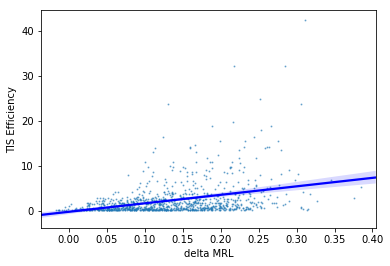

In [21]:
# ACG
acg_df = tis_nonaug_df_sub[tis_nonaug_df_sub["TIS_Sequence"].str[-4:-1] == "ACG"]
df = score(acg_df, top_df, paper_model, start=8, length=8, paper=True)

Pearson: 0.239, p-val: 0.000, squared: 0.057, Spearman: 0.102, p-val: 0.001


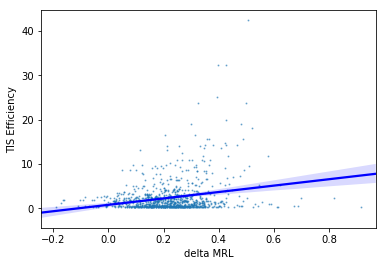

In [45]:
df = score(acg_df, top_df, new_model, start=8, length=8, paper=False)

Pearson: 0.366, p-val: 0.000, squared: 0.134, Spearman: 0.295, p-val: 0.000


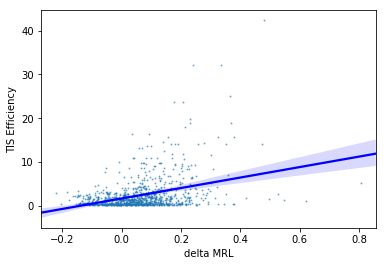

In [23]:
df = score(acg_df, top_df, new_model, start=39, length=8, paper=False)

GUG and ACG prediction, meanwhile appear more difficult (and also vary more with position). Possibly the strength of these codons is more sensitive to the broader sequence and cell context.